# The ZnFlow Package

Define Node connections using a directional multigraph.
Nodes are connected through Node attributes.
A Node can have multiple connections to another Node through different Attributes.
Each Node is defined by a unique `_id_` which could be automatically generated based on the state of the Node.

In [1]:
import zninit

import znflow

A Node is inherited from `znflow.Node` and can have many different `znflow.EdgeAttribute` that will connect the Nodes to  other Nodes or behave as inputs / outputs from the Node.
In general a `Node` is very similar to a dataclass and even implements a `_post_init_` method.
We equip our `Node` with a `run` method that computes the `outputs` based on the `inputs`.

In [2]:
class Node(zninit.ZnInit, znflow.Node):
    inputs = zninit.Descriptor()
    outputs = zninit.Descriptor(None)

    def run(self):
        self.outputs = self.inputs * 2

In [3]:
node1 = Node(inputs=25)
node1.run()
node1

Node(inputs=25, outputs=50)

We can now create multiple Nodes and connect them. Nodes are connected through `znflow.GraphManager` as follows.
Every Node inside the contextmanager will automatically be stored inside the `dag` object.

In [4]:
with znflow.DiGraph() as graph:
    node1 = Node(inputs=25)
    node2 = Node(inputs=node1.outputs)  # TODO Node(inputs=node1)

If we look at the new Node, we see that `Node.inputs` is now a `NodeConnector` to the connected Node.

In [5]:
node1

Node(inputs=25, outputs=None)

In [6]:
node2

Node(inputs=Connection(instance=Node(inputs=25, outputs=None), attribute='outputs'), outputs=None)

Using `networkx` we can visualize the connection.

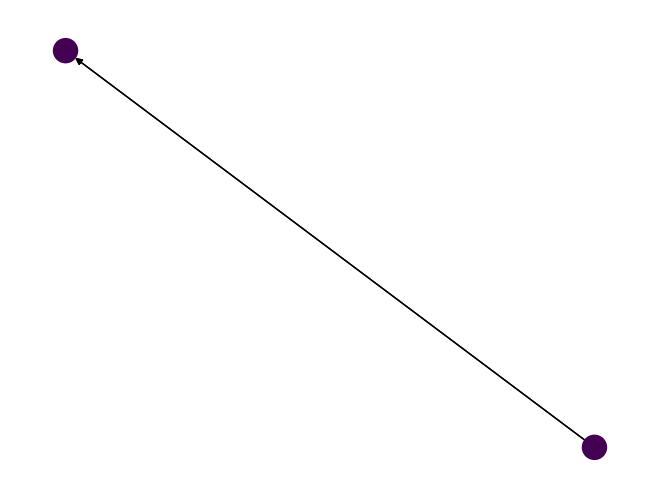

In [7]:
znflow.draw(graph)

Another way of connecting Nodes is through `znflow.DiGraph().write_graph`.
It is important to mention, that we can not use `node1.outputs` here, because we know `node1.outputs is None`. Therefore, we have to replace it by `node1 @ "outputs"`

In [8]:
node1 = Node(inputs=25)
node2 = Node(inputs=node1 @ "outputs")
print(f"{node1.outputs = }")
print(f'{node1 @ "outputs" = }')
print(f"{node2 = }")

node1.outputs = None
node1 @ "outputs" = Connection(instance=Node(inputs=25, outputs=None), attribute='outputs')
node2 = Node(inputs=Connection(instance=Node(inputs=25, outputs=None), attribute='outputs'), outputs=None)


In [ ]:
graph = znflow.DiGraph()
graph.add_znflow_node(node1)
graph.add_znflow_node(node2)
graph.add_connections(node2.inputs, v_of_edge=node2, v_attr="inputs")

In [10]:
graph.nodes

NodeView((UUID('b3e943cd-9962-454b-a9c8-8cc7ab27d7d3'), UUID('96cdda00-4bd6-4296-b980-57187adddf46')))

In [11]:
[graph.edges[x] for x in graph.edges]

[{'u_attr': 'outputs', 'v_attr': 'inputs'}]

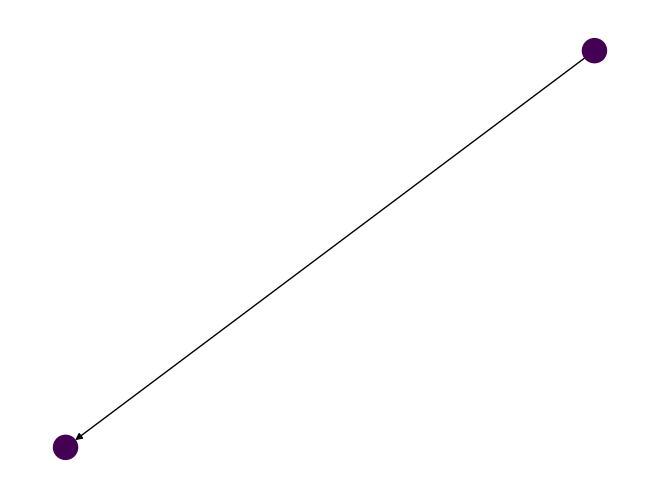

In [12]:
znflow.draw(graph)

# Run the Graph

First let's build some more interesting graphs:

In [13]:
class SumNodes(zninit.ZnInit, znflow.Node):
    inputs = zninit.Descriptor()
    outputs = zninit.Descriptor(None)

    def run(self):
        self.outputs = sum(self.inputs)

In [14]:
with znflow.DiGraph() as graph:
    node1 = Node(inputs=5)
    node2 = Node(inputs=10)
    node3 = Node(inputs=node1.outputs)
    node4 = Node(inputs=node2.outputs)
    node5 = SumNodes(inputs=[node3.outputs, node4.outputs])
    node6 = SumNodes(inputs=[node2.outputs, node5.outputs])
    node7 = SumNodes(inputs=[node6.outputs])

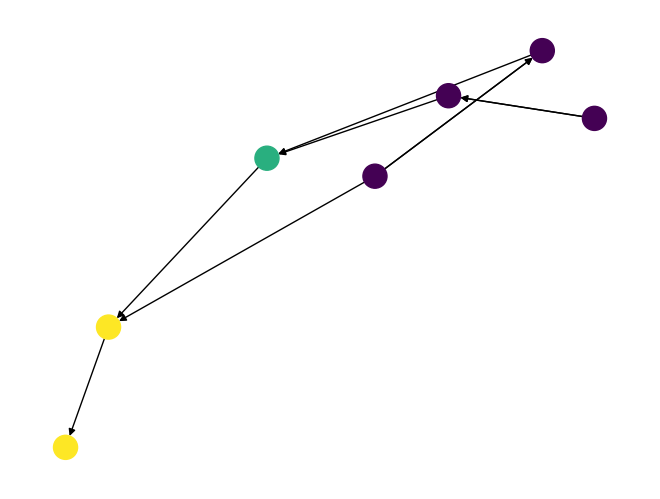

In [15]:
znflow.draw(graph)

In [16]:
graph.run()  # default is to call node.run()
graph.nodes

NodeView((UUID('9f70416e-380e-4f19-9f42-5caf85d1c109'), UUID('8fe84ca3-150c-4922-8268-68ce819d84c3'), UUID('98af6ef7-fd1f-460d-b917-8d1bacb3c3c0'), UUID('90562226-d151-448b-93a5-72eb0ec08754'), UUID('e92c271c-7641-4baa-a728-02b8ee277277'), UUID('c3aaef07-b4fa-4b12-9aeb-5155cd3943b3'), UUID('babf5cee-d45d-476b-97ab-8aacfe05a410')))

Or even more nested

In [17]:
import random

k = 3
j = 3
i = 3

with znflow.DiGraph() as graph:
    kdx_nodes = []
    for kdx in range(k):
        jdx_nodes = []
        for jdx in range(j):
            idx_nodes = []
            for idx in range(i):
                idx_nodes.append(Node(inputs=random.random()))
            jdx_nodes.append(SumNodes(inputs=[x.outputs for x in idx_nodes]))
        kdx_nodes.append(SumNodes(inputs=[x.outputs for x in jdx_nodes]))

    end_node = SumNodes(inputs=[x.outputs for x in kdx_nodes])

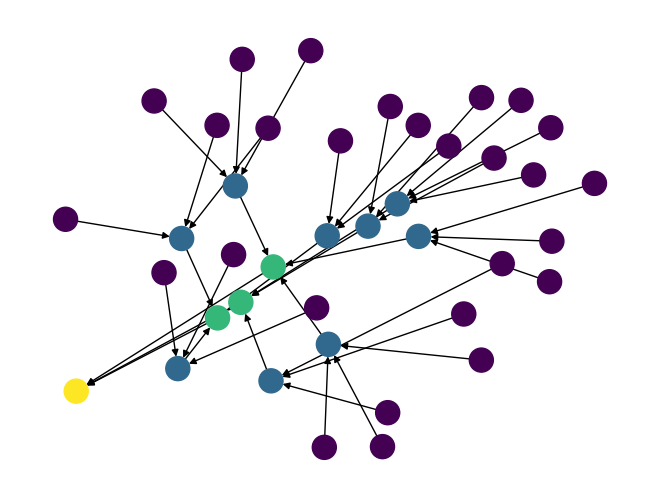

In [18]:
# nx.draw(dag)
znflow.draw(graph)

In [19]:
%time graph.run() # default is to call node.run()

# # [x._id_ for x in dag.nodes]
[x for x in graph.nodes]

CPU times: user 205 ms, sys: 7.81 ms, total: 213 ms
Wall time: 215 ms


[UUID('f4c955a6-e635-4d7e-9b6f-1d87a2e9394d'),
 UUID('5b2dbf54-4ba3-4f54-9d5d-e0cd134c2df3'),
 UUID('2f0c4080-5265-475c-ab10-9bbcb00686a1'),
 UUID('1d69451d-7764-4e7f-9dbe-532cf6f8116f'),
 UUID('4db270e7-16d6-4231-832c-03a0c4cc43ec'),
 UUID('044459b2-350c-4b7e-a676-440ec520114f'),
 UUID('b53a55d6-77d4-4248-8e87-20f960292ec9'),
 UUID('b584b093-c01d-4bea-bda8-354dcd64d7eb'),
 UUID('62a19c65-e9c2-4598-a9ee-a795d59d5fe1'),
 UUID('7cc266b1-1177-4108-a53e-2fd3e553460d'),
 UUID('4ad42750-ca1c-41c8-840c-af44f2b04f32'),
 UUID('4db40e05-733c-4548-b50a-0b195b486ebf'),
 UUID('1fed7aa2-2677-4011-85a0-050bf4d79879'),
 UUID('51c5dd04-6d47-4877-b1d6-bdbc5d9ef789'),
 UUID('ba62491d-23dd-4606-b38c-0ed07a1b7aa3'),
 UUID('e82870bc-3c8a-4e94-b2c7-bc99c64879a1'),
 UUID('f78160f1-9df7-4c4e-ad8c-23377c361a39'),
 UUID('a3b342b9-9842-41a6-9eae-bb5a9dad5417'),
 UUID('1572a4f7-c7fa-465e-b9e4-5f5b0d3eb91e'),
 UUID('7b22fc23-b999-4ed9-ac3b-fbe69c2be9c9'),
 UUID('10581165-7f35-468c-a389-82dad843de38'),
 UUID('38ce7b

In [20]:
end_node

SumNodes(inputs=[9.245727534191499, 7.098558270790515, 6.575734731170973], outputs=22.92002053615299)